In [1]:
# Importing required libraries and frameworks
import pandas as pd
import numpy as np
import glob
import warnings
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import Normalizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import SGDRegressor, LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [2]:
def num_extract(string):
    pattern = r'participant_(\d+)'
    match = re.search(pattern, string)
    if match:
        return int(match.group(1))
    else:
        return None

In [3]:
def feature_selection(df):
    left_column = 'Pupil diameter left'
    right_column = 'Pupil diameter right'
    
    # Iterate through each row in the DataFrame to find the first non-null row for left and right columns
    for idx, row in df.iterrows():
        if not pd.isnull(row[left_column]):
            starting_idx_left = idx
            break
    else:
        starting_idx_left = None  # Set to None if no non-null row is found in the left column
    
    for idx, row in df.iterrows():
        if not pd.isnull(row[right_column]):
            starting_idx_right = idx
            break
    else:
        starting_idx_right = None  # Set to None if no non-null row is found in the right column
    
    if starting_idx_left is not None and starting_idx_right is not None:
        if starting_idx_left < starting_idx_right:
            selected_df = df.iloc[starting_idx_left::3]  # Incrementing 3 rows each time
        else:
            selected_df = df.iloc[starting_idx_right::3]
    elif starting_idx_left is not None:
        selected_df = df.iloc[starting_idx_left::3]
    elif starting_idx_right is not None:
        selected_df = df.iloc[starting_idx_right::3]
    else:
        selected_df = pd.DataFrame()  # Return an empty DataFrame if both starting indices are None
    
    return selected_df


# Function for type casting object data points into numerical data points
def numeric_conversion(df):
    df = df.replace(',','.',regex = True)
    for col in df.columns:
        if not pd.api.types.is_numeric_dtype(df[col]):
            df[col] = pd.to_numeric(df[col], errors='ignore')
    return df

def removing_duplicates(df):
    df = df.drop_duplicates(subset='Recording timestamp')
    return df

def removing_unwanted_columns(df, columns_to_remove):
    df = df.drop(columns=columns_to_remove, axis=1)
    return df

def unique_val_cols(df):
    unique_values = []
    for column in df.columns :
        if column != 'Participant name' and column != 'Recording timestamp':
    # If columns have unique values more than 1, it means that columns have variance
            if df[column].nunique() <= 1:
                unique_values.append(column)
    df = df.drop(columns = unique_values) # Removing columns with zero variance
    return df

In [4]:
def data_preprocessing(df, columns_to_remove):
    # Numeric Conversion
    df = df.applymap(lambda x: x.replace(',', '.') if isinstance(x, str) else x)
    for col in df.columns:
        if not pd.api.types.is_numeric_dtype(df[col]):
            df[col] = pd.to_numeric(df[col], errors='ignore')
    
    # Duplicate Removal
    df = df.drop_duplicates(subset='Recording timestamp')
    
    # Remove Columns as specified
    try:
        df = df.drop(columns=columns_to_remove, axis=1)
    except KeyError:
        columns_to_remove = [i for i in columns_to_remove if i in df.columns]
        df = df.drop(columns=columns_to_remove, axis=1)
    
    # Remove Columns with Unique Values
    unique_values = [column for column in df.columns if column not in ['Participant name', 'Recording timestamp'] and df[column].nunique() <= 1]
    df = df.drop(columns=unique_values)
    
    return df

In [5]:
def get_empathy_score(df_main, df_scores):
    # Extracting empathy scores from the df_scores DataFrame and creating a dictionary
    # where participant numbers are keys and their corresponding empathy scores are values.
    empathy_scores = {int(row['Participant nr']): row['Total Score extended'] for _, row in df_scores.iterrows()}
    
    # Creating a copy of the df_main DataFrame to avoid modifying the original DataFrame
    df_copy = df_main.copy()
    
    # Mapping the empathy scores to the 'Participant name' column in the copied DataFrame.
    # If a participant's name is not found in the empathy_scores dictionary, their score will be filled with 0.
    df_copy['Empathy Score'] = df_copy['Participant name'].map(empathy_scores).fillna(0)
    
    # Returning the copied DataFrame with added 'Empathy Score' column and the empathy_scores dictionary.
    return df_copy, empathy_scores


In [6]:
def fill_missing_values(df):
    # Creating an instance of the IterativeImputer with specified parameters
    fill = IterativeImputer(max_iter=10, random_state=0)
    
    # Fitting the imputer to the input DataFrame and transforming it to fill missing values
    filler = fill.fit_transform(df)
    
    # Creating a new DataFrame using the filled values and maintaining the original column names
    new_df = pd.DataFrame(filler, columns=df.columns)
    
    # Returning the new DataFrame with missing values filled
    return new_df


In [7]:
def analyze_eye_data(input_df):
    # List of selected columns for analysis
    selected_columns = [
        'Gaze point X', 'Gaze point Y',
        'Pupil diameter left', 'Pupil diameter right',
        'Eye position left X (DACSmm)', 'Eye position left Y (DACSmm)',
        'Eye position left Z (DACSmm)', 'Eye position right X (DACSmm)',
        'Eye position right Y (DACSmm)', 'Eye position right Z (DACSmm)',
        'Gaze event duration', 'Empathy Score'
    ]
    
    try:
        # Finding mode (most frequent value) for each selected column
        mode_values = input_df[selected_columns].mode().iloc[0]
    except KeyError as e:
        # Handling the case where a selected column is not found in the input DataFrame
        missing_col = str(e).strip('\'[]\'')
        print(f"Column {missing_col} not found in the dataframe")
        return None
    
    # Creating a DataFrame with mode values and selected columns
    mode_df = pd.DataFrame([mode_values], columns=selected_columns)
    
    # Adding participant-related statistics to the mode DataFrame
    mode_df['Participant name'] = input_df['Participant name'].iloc[0]
    mode_df['Avg Gaze event duration'] = input_df['Gaze event duration'].mean()
    mode_df['Total Gaze event duration'] = input_df['Gaze event duration'].sum()
    
    # Returning the mode DataFrame with analyzed data
    return mode_df


In [8]:
def drop_correlation(df):
    corr_matrix = df.corr()

    # Select highly correlated features
    highly_correlated_features = set()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > 0.7:
                colname_i = corr_matrix.columns[i]
                highly_correlated_features.add(colname_i)

    print(f'Highly correlated features\n{highly_correlated_features}')
    
    # Remove highly correlated features
    df = df.drop(highly_correlated_features, axis=1)
    return df

In [9]:
def data_preparation(df):
    # Data Normalization
    normalizer = Normalizer()
    df_copy = df.copy()
    df_copy = normalizer.fit_transform(df_copy)
    df_copy = pd.DataFrame(df_copy, columns=df.columns)
    
    # Separating Features and Target
    X, y = df_copy.drop('Empathy Score', axis=1), df_copy['Empathy Score']
    
    # Calculating the variance of the target variable
    var = np.var(y)
    
    # Dropping Correlated Features
    X = drop_correlation(X)
    
    # Cross-Validation and Model Training
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    model = DecisionTreeRegressor(random_state=42)
    
    # Defining custom scoring metrics for cross-validation
    scoring = {
        'r2': make_scorer(lambda y_true, y_pred: 1 - (mean_squared_error(y_true, y_pred) / var)),
        'mse': 'neg_mean_squared_error'
    }

    # Performing cross-validation
    cv_results = cross_validate(model, X, y, cv=kf, scoring=scoring)
    r2_scores = cv_results['test_r2']

    # Printing and plotting cross-validation results
    for i, r2 in enumerate(r2_scores, start=1):
        print(f"Cross-Validation Fold {i}: R2 score = {r2:.3f}")

    plt.figure(figsize=(8, 6))
    sns.lineplot(x=range(1, 11), y=r2_scores, marker='o')
    plt.xlabel('Fold')
    plt.ylabel('R-Squared')
    plt.title('Cross-Validation R-Squared Scores')
    plt.show()
    
    # Returning processed features (X), target (y), and target variance (var)
    return X, y, var


In [10]:
def model_training(X_train, X_test, y_train, y_test, var):
    # SGDRegressor
    sgd_model = SGDRegressor(random_state=13)
    sgd_model.fit(X_train, y_train)
    y_pred_sgd = sgd_model.predict(X_test)
    mse_sgd = mean_squared_error(y_test, y_pred_sgd)
    r2_sgd = 1 - (mse_sgd / var)
    print("SGDRegressor:")
    print("R2 score: {:.3f}".format(r2_sgd))
    print("MSE: {:.3f}".format(mse_sgd))

    # Linear Regression
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    y_pred_lr = lr_model.predict(X_test)
    mse_lr = mean_squared_error(y_test, y_pred_lr)
    r2_lr = 1 - (mse_lr / var)
    print("\nLinear Regression:")
    print("R2 score: {:.3f}".format(r2_lr))
    print("MSE: {:.3f}".format(mse_lr))

    # XGBoost Regressor
    xgb_model = XGBRegressor(random_state=13)
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)
    mse_xgb = mean_squared_error(y_test, y_pred_xgb)
    r2_xgb = 1 - (mse_xgb / var)
    print("\nXGBoost Regressor:")
    print("R2 score: {:.3f}".format(r2_xgb))
    print("MSE: {:.3f}".format(mse_xgb))

    # Neural Networks (Deep Neural Networks)
    nn_model = keras.Sequential([
        keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1)
    ])

    nn_model.compile(optimizer='adam', loss='mean_squared_error')
    nn_model.fit(X_train, y_train, epochs=50, batch_size=32)
    y_pred_nn = nn_model.predict(X_test).flatten()
    mse_nn = mean_squared_error(y_test, y_pred_nn)
    r2_nn = 1 - (mse_nn / var)
    print("\nNeural Networks (Deep Neural Networks):")
    print("R2 score: {:.3f}".format(r2_nn))
    print("MSE: {:.3f}".format(mse_nn))

    # Visualize the predictions against the actual values for NN
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred_nn, alpha=0.5, color='b', label='Predictions')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='r', linestyle='--', label='Perfect Fit')
    plt.title("Neural Network: Actual vs. Predicted Empathy Scores")
    plt.xlabel("Actual Empathy Scores")
    plt.ylabel("Predicted Empathy Scores")
    plt.legend()
    plt.grid(True)
    plt.show()


In [11]:
# Path to the group 3 eye tracking data files and loading questionnaire data
path = r"C:\Users\USER\Desktop\EMPATHY\EyeT\EyeT_group_dataset_III_image_name_letter_card_participant_**_trial_*.csv"
questionnaire = pd.read_csv(r"C:\Users\USER\Desktop\EMPATHY\Questionnaire_datasetIB.csv", encoding='ISO-8859-1')

# Finding all CSV files in the specified path
filename = glob.glob(path)

# Creating an empty DataFrame to store aggregated results
df = pd.DataFrame()

# Initializing a counter
num = 0

# Looping through each CSV file
for file in filename:
    num += 1
    print(num, end=', ')
    
    # Reading the CSV file into a temporary DataFrame
    df_pre = pd.read_csv(file)
    
    # Extracting participant number from the filename
    participant_number = num_extract(file)
    
    # Adding 'Participant name' column to the temporary DataFrame
    df_pre['Participant name'] = participant_number
    
    # Applying feature selection to the temporary DataFrame
    selected_df = feature_selection(df_pre)
    
    # List of columns to be removed
    columns_to_remove = ['Eye movement type','Computer timestamp','Eye movement type index','Unnamed: 0','Sensor',
                     'Event','Event value','Validity left','Validity right','Presented Stimulus name',
                     'Presented Media width','Presented Media name','Presented Media height','Presented Media position X (DACSpx)',
                     'Presented Media position Y (DACSpx)','Original Media width','Original Media height','Mouse position X','Mouse position Y']
    
    # Removing specified columns from the selected DataFrame
    selected_df = data_preprocessing(selected_df, columns_to_remove)
    
    # Adding empathy scores from questionnaire to the selected DataFrame
    selected_df, empathy_scores = get_empathy_score(selected_df, questionnaire)
    
    # Filling missing values in the selected DataFrame
    selected_df = fill_missing_values(selected_df)
    
    # Analyzing eye tracking data in the selected DataFrame
    selected_df = analyze_eye_data(selected_df)
    
    # Concatenating the processed selected DataFrame to the main aggregated DataFrame
    df = pd.concat([df, selected_df])


1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, Column "['Pupil diameter left'] not in index" not found in the dataframe
38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, Column "['Pupil diameter right'] not in index" not found in the dataframe
73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, Column "['Pupil diameter left'] not in index" not found in the dataframe
90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, Column "['Pupil diameter right'] not in index" not found in the dataframe
118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163,

In [12]:
df

,Gaze point X,Gaze point Y,Pupil diameter left,Pupil diameter right,Eye position left X (DACSmm),Eye position left Y (DACSmm),Eye position left Z (DACSmm),Eye position right X (DACSmm),Eye position right Y (DACSmm),Eye position right Z (DACSmm),Gaze event duration,Empathy Score,Participant name,Avg Gaze event duration,Total Gaze event duration
0,958.0,-138.0,3.11,3.06,192.3,54.2,728.7,260.3,51.0,732.0,17.0,151.0,11.0,165.038219,410615.088776
0,979.0,-87.0,2.95,2.95,190.8,54.8,728.2,258.1,49.5,733.9,17.0,151.0,11.0,153.129622,368583.000000
0,983.0,119.0,2.94,2.84,212.5,119.3,895.4,279.2,120.5,894.3,17.0,151.0,11.0,73.068355,165353.687315
0,985.0,553.0,3.02,3.03,208.5,125.7,886.9,275.1,124.1,885.7,17.0,151.0,11.0,58.720443,250853.732008
0,971.0,541.0,2.88,2.94,208.2,125.0,895.6,275.0,123.0,892.3,17.0,151.0,11.0,54.411034,231410.129276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,982.0,-115.0,3.05,2.93,190.7,114.1,786.8,258.7,116.9,791.4,17.0,99.0,9.0,165.190136,821820.927326
0,946.0,-110.0,2.97,2.96,189.8,110.2,744.0,257.7,106.4,756.5,17.0,99.0,9.0,257.756250,857039.529816
0,929.0,253.0,2.93,2.91,185.9,109.2,735.5,253.0,108.3,742.1,17.0,99.0,9.0,180.065786,271359.139034
0,969.0,145.0,3.53,3.27,210.7,109.3,867.1,277.2,110.4,867.1,17.0,99.0,9.0,111.932230,216365.000000


Highly correlated features
{'Eye position left Z (DACSmm)', 'Participant name', 'Total Gaze event duration', 'Eye position right Z (DACSmm)', 'Eye position right X (DACSmm)', 'Eye position left X (DACSmm)', 'Gaze point Y', 'Eye position right Y (DACSmm)', 'Eye position left Y (DACSmm)'}
Cross-Validation Fold 1: R2 score = 0.956
Cross-Validation Fold 2: R2 score = 0.931
Cross-Validation Fold 3: R2 score = 0.891
Cross-Validation Fold 4: R2 score = 0.964
Cross-Validation Fold 5: R2 score = -0.370
Cross-Validation Fold 6: R2 score = 0.910
Cross-Validation Fold 7: R2 score = 0.966
Cross-Validation Fold 8: R2 score = 0.927
Cross-Validation Fold 9: R2 score = 0.964
Cross-Validation Fold 10: R2 score = 0.863


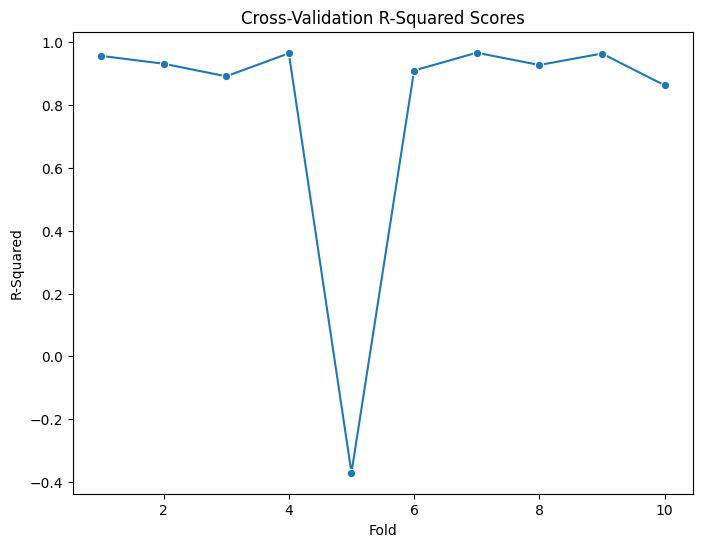

SGDRegressor:
R2 score: 0.523
MSE: 0.000

Linear Regression:
R2 score: -3.280
MSE: 0.000

XGBoost Regressor:
R2 score: 0.927
MSE: 0.000
Epoch 1/50
9/9 [==============================] - 1s 7ms/step - loss: 1.0142e-05
Epoch 2/50
9/9 [==============================] - 0s 3ms/step - loss: 2.3697e-05
Epoch 3/50
9/9 [==============================] - 0s 4ms/step - loss: 5.0671e-06
Epoch 4/50
9/9 [==============================] - 0s 4ms/step - loss: 6.8781e-06
Epoch 5/50
9/9 [==============================] - 0s 4ms/step - loss: 9.2082e-07
Epoch 6/50
9/9 [==============================] - 0s 3ms/step - loss: 1.4128e-06
Epoch 7/50
9/9 [==============================] - 0s 4ms/step - loss: 4.3698e-07
Epoch 8/50
9/9 [==============================] - 0s 4ms/step - loss: 3.9693e-08
Epoch 9/50
9/9 [==============================] - 0s 4ms/step - loss: 1.0657e-07
Epoch 10/50
9/9 [==============================] - 0s 4ms/step - loss: 6.8367e-08
Epoch 11/50
9/9 [==============================] - 0s

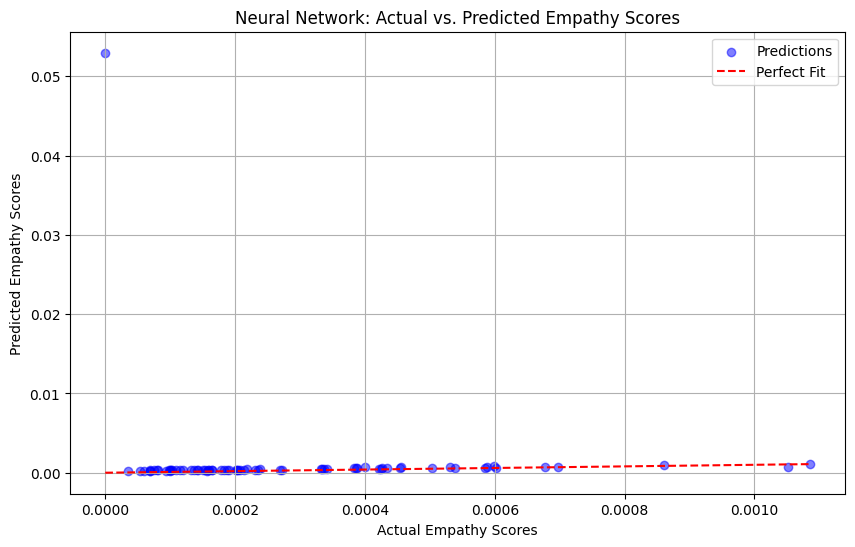

In [13]:
X, y, var = data_preparation(df)
try:
    X = X.drop('Participant name', axis=1)
except KeyError:
    pass

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = model_training(X_train, X_test, y_train, y_test,var)


In [14]:
# Path to the group 2 eye tracking data files and loading questionnaire data
group_2_path = r"C:\Users\USER\Desktop\EMPATHY\EyeT\EyeT_group_dataset_II_image_name_grey_blue_participant_**_trial_*.csv"
questionnaire_II = pd.read_csv(r"C:\Users\USER\Desktop\EMPATHY\Questionnaire_datasetIB.csv", encoding='ISO-8859-1')

# Finding all CSV files in the specified path
filename = glob.glob(group_2_path)

# Creating an empty DataFrame to store aggregated results
df_2 = pd.DataFrame()

# Initializing a counter
num = 0

# Looping through each CSV file
for file in filename:
    num += 1
    print(num, end=', ')
    
    # Reading the CSV file into a temporary DataFrame
    temporary = pd.read_csv(file)
    
    # Extracting participant number from the filename
    participant_number = num_extract(file)
    
    # Adding 'Participant name' column to the temporary DataFrame
    temporary['Participant name'] = participant_number
    
    # Applying feature selection to the temporary DataFrame
    selected_df = feature_selection(temporary)
    
    # List of unwanted columns
    unwanted_cols = ['Eye movement type','Computer timestamp','Eye movement type index','Unnamed: 0','Sensor',
                     'Event','Event value','Validity left','Validity right','Presented Stimulus name','Presented Media width',
                     'Presented Media name','Presented Media height','Presented Media position X (DACSpx)',
                     'Presented Media position Y (DACSpx)','Original Media width','Original Media height']
    
    # Removing unwanted columns from the selected DataFrame
    selected_df = data_preprocessing(selected_df, unwanted_cols)
    
    # Adding empathy scores from questionnaire to the selected DataFrame
    selected_df, empathy_scores = get_empathy_score(selected_df, questionnaire_II)
    
    # Filling missing values in the selected DataFrame
    selected_df = fill_missing_values(selected_df)
    
    # Analyzing eye tracking data in the selected DataFrame
    selected_df = analyze_eye_data(selected_df)
    
    # Concatenating the processed selected DataFrame to the main aggregated DataFrame
    df_2 = pd.concat([df_2, selected_df])


1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, Column "['Pupil diameter left'] not in index" not found in the dataframe
54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 

Highly correlated features
{'Eye position left Z (DACSmm)', 'Participant name', 'Total Gaze event duration', 'Eye position right Z (DACSmm)', 'Eye position right X (DACSmm)', 'Eye position left X (DACSmm)', 'Gaze point Y', 'Eye position right Y (DACSmm)', 'Eye position left Y (DACSmm)'}
Cross-Validation Fold 1: R2 score = 0.956
Cross-Validation Fold 2: R2 score = 0.931
Cross-Validation Fold 3: R2 score = 0.891
Cross-Validation Fold 4: R2 score = 0.964
Cross-Validation Fold 5: R2 score = -0.370
Cross-Validation Fold 6: R2 score = 0.910
Cross-Validation Fold 7: R2 score = 0.966
Cross-Validation Fold 8: R2 score = 0.927
Cross-Validation Fold 9: R2 score = 0.964
Cross-Validation Fold 10: R2 score = 0.863


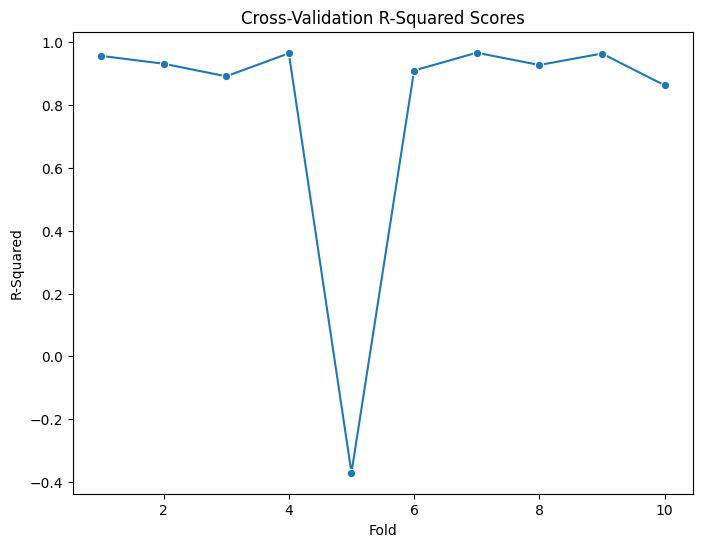

SGDRegressor:
R2 score: 0.523
MSE: 0.000

Linear Regression:
R2 score: -3.280
MSE: 0.000

XGBoost Regressor:
R2 score: 0.927
MSE: 0.000
Epoch 1/50
9/9 [==============================] - 1s 8ms/step - loss: 1.3290e-05
Epoch 2/50
9/9 [==============================] - 0s 8ms/step - loss: 4.3055e-05
Epoch 3/50
9/9 [==============================] - 0s 7ms/step - loss: 2.0537e-07
Epoch 4/50
9/9 [==============================] - 0s 8ms/step - loss: 1.0121e-05
Epoch 5/50
9/9 [==============================] - 0s 6ms/step - loss: 1.5694e-07
Epoch 6/50
9/9 [==============================] - 0s 6ms/step - loss: 7.8291e-07
Epoch 7/50
9/9 [==============================] - 0s 6ms/step - loss: 8.5904e-08
Epoch 8/50
9/9 [==============================] - 0s 6ms/step - loss: 1.4160e-07
Epoch 9/50
9/9 [==============================] - 0s 6ms/step - loss: 1.0366e-07
Epoch 10/50
9/9 [==============================] - 0s 6ms/step - loss: 1.6370e-07
Epoch 11/50
9/9 [==============================] - 0s

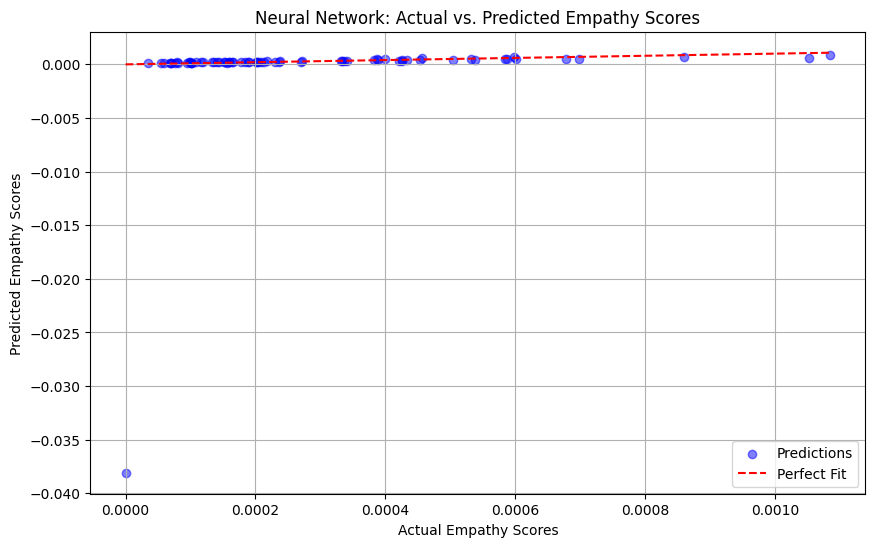

In [15]:
X, y, var = data_preparation(df)
try:
    X = X.drop('Participant name', axis=1)
except KeyError:
    pass

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = model_training(X_train, X_test, y_train, y_test,var)